# Visual Introduction to Predictive Modelling

Be sure to check out the video version of the analysis in <a href="https://youtu.be/muz80rOHYdc
">Youtube</a>! Use button in top navigation bar to display source code blocks. The article is best viewed in Google Chrome browser.

## Introduction

Predictive modelling means predicting outcomes using statistical techniques. It can be used both for predicting future events as well as outcomes that have already taken place but are unknown to observer. Predictive modelling is widely used in academic research but also in different industries touching upon everyday phenomena. Examples include, but are not limited, to

- crime detection
- quantifying risk, e.g. in financial credit risk modelling
- recommendation engines, such as ones used by Netflix and Google
- in medicine detecting patients with fatal diseases.

This article serves as an introduction to predictive modelling. We are going to walk through the steps in predictive modelling pipeline, including problem statement, preparing data, fitting a model, and eventually using the model to predict outcomes. In this tutorial we will be looking at how to predict whether a given cancer tumor is malignant or benign. The aim is gaining understanding on an intuitive level; we'll skip most of the math stuff and describe the problem setting and solution visually. The article functions as background information for the animated video version of the tutorial found in <a href="https://youtu.be/muz80rOHYdc
">Youtube</a>, be sure to check it out!

We will use logistic regression as our weapon of choice. It is the loyal work horse of many statistical modelling tasks and often employed as a less complex model against which e.g. more advanced machine learning models are tested against. 

Like other models used for predictive modelling, logistic regression is used to estimate the <i>probability of class membership</i>. That is, for a given observation we would like to calculate the probability of it belonging to a certain pre-defined class. When the estimated class membership probability is coupled with a <i>decision rule</i>, logistic regression model can be turned into a <i>classifier</i> assigning observations into different classes. See discussion <a href="https://stats.stackexchange.com/questions/127042/why-isnt-logistic-regression-called-logistic-classification">here</a> about the ambiguity of whether logistic regression should be called 'regression' or 'classification'.

In this post we will focus on a simple binary class case. That is, we assume that there are two target classes and it is our job to determine the probabilities of a given observation in belonging to either class. The Python source code is included in the cells within the text (use button in top navigation bar to display code blocks). We use mainly two libraries: <i>scikit learn</i> to build the model and <i>matplotlib</i> to visualize the results. 

Small disclaimer before we begin: Code for the analysis is by no means written in very efficient matter nor does it adher to any common style guides. Possible mistakes are my own and I am grateful to anyone pointing them out.

In [1]:
# Dependencies and helper functions for analysis 
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display_html
from IPython.display import display
#%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

figsize = (26,10)
ticklabel_size = 22
axislabel_size = 24
title_size = 28
blob_size = 90
blob_size_bigger = 160
edgecolor = 'k'
linewidths = 0.5
legendsize = 26
plot_text_size = 22

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline; border:0px"')          
    display_html(html_str,raw=True)

def plot_2d_decision_regions(X, y, model, class_names, title = None, mesh_step_size = 0.1, correction = 1, featured = 0, style = 'normal',lims = None):
    """
    Function to produce 2 featured graph with decision regions.
    """
    import matplotlib.patches as mpatches    
    
    if lims == None:
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
        y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    else:
        x_min = lims[0]
        x_max = lims[1]
        y_min = lims[2]
        y_max = lims[3]    
        
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Colors    
    cmap = plt.cm.PuOr
    colors = [cmap(0.3), cmap(0.9)]    
    cmap = cmap.from_list('Custom cmap', colors, 2)
    
    # Figure
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    scats = []
    for i in range(2):
        ax.scatter(X[y.values == i,0], X[y.values == i,1], alpha = 0.8, label = i, color = colors[i], s = blob_size_bigger, edgecolor = edgecolor, linewidths = linewidths)
    
    plt.imshow(Z, interpolation = 'nearest', cmap = cmap, alpha = 0.12,
               extent=(x_min, x_max, y_min, y_max), origin = 'lower')
    
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax.legend(handles = patches, loc='upper right', prop={'size': legendsize})     
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('2nd PCA direction', fontsize = axislabel_size)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('auto')
    plt.tight_layout()
    if title:
        ax.set_title(title, fontsize = title_size)
        
    if featured == 1:
        ax.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = edgecolor, s = blob_size_bigger)      
            
    if style == 'animation':
        ax.set_title(title, color = 'white', fontsize = title_size)
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')        
        return fig    
        
def plot_confusion_matrix(y_test, y_pred, title, style = 'normal'):
    """
    Function to produce confusion matrix graph.
    """    
    labelsno = len(np.unique(y_test))
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index = [i for i in range(0,labelsno)],
                  columns = [i for i in range(0,labelsno)])
    df_cm = df_cm.sort_index(axis = 0, ascending=False)
    df_cm = df_cm.sort_index(axis = 1, ascending=False)
    
    fig = plt.figure(figsize = (20,7.5))
    ax = fig.add_subplot(111)
    ax2 = sns.heatmap(df_cm, annot=True, annot_kws={"size": 24})
    cbar = ax2.collections[0].colorbar
    
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=20)    
    ax.set_title(title + '\nAccuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)), fontsize = title_size)    
    ax.set_xlabel('True label', fontsize = axislabel_size)
    ax.set_ylabel('Predicted label', fontsize = axislabel_size)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax2.tick_params(axis='both', which='major', labelsize=ticklabel_size)    
    
    if style == 'animation':
        ax.set_title(title + '\nAccuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)), color = 'white', fontsize = title_size)        
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')     
        ax2.figure.axes[-1].xaxis.label.set_color('white')
        cbar.ax.tick_params(axis='y', colors='white') 
        return fig

def plot_2d_decision_probs(X, y, model, class_names, title = None, mesh_step_size = 0.1, correction = 1, lims = None, featured = 0):
    """
    Function to produce 2 featured graph with estimated probabilities.
    """    
    import matplotlib.patches as mpatches        
    no_targets = len(y.unique())
    
    if lims == None:
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
        y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    else:
        x_min = lims[0]
        x_max = lims[1]
        y_min = lims[2]
        y_max = lims[3]

    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    
    cmap = plt.cm.PuOr
    colors = [cmap(0.3), cmap(0.9)]    
    cmap = cmap.from_list('Custom cmap', colors, 2)
    
    # Figure
    fig = plt.figure(figsize = figsize)    
    ax = fig.add_subplot(111)
    scats = []

    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.scatter(X[y.values == 0,0], X[y.values == 0,1], alpha = 0.9, label = '0', color = colors[0], s = blob_size_bigger, edgecolor = edgecolor, linewidths = linewidths)
    ax.scatter(X[y.values == 1,0], X[y.values == 1,1], alpha = 0.9, label = '1', color = colors[1], s = blob_size_bigger, edgecolor = edgecolor, linewidths = linewidths)

    plt.imshow(Z, interpolation = 'nearest', cmap = 'PuOr', alpha = 0.08,
               extent=(x_min, x_max, y_min, y_max), origin = 'lower')
    
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax.legend(handles = patches, loc='upper right', prop={'size': legendsize}) 
    

    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('2nd PCA direction', fontsize = axislabel_size)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('auto')    
    plt.tight_layout()   
    
    if title:
        ax.set_title(title, fontsize = title_size)
        
    if featured == 1:
        ax.scatter(X[113, 0], X[113, 1], c = 'r', edgecolor = edgecolor, s = blob_size_bigger)                
        
def plot_2d(X, y, title, class_names, featured = 0, lims = None):
    """
    Function to produce 2-featured scatter plot.
    """    
    correction = 500    
    import matplotlib.patches as mpatches
    
    if lims == None:
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
        y_min, y_max = X[:, 1].min() - correction, X[:, 1].max() + correction
    else:
        x_min = lims[0]
        x_max = lims[1]
        y_min = lims[2]
        y_max = lims[3]    
    
    # Color map
    cmap = plt.cm.PuOr
    colors = [cmap(0.3), cmap(0.9)]    
    cmap = cmap.from_list('Custom cmap', colors, 2)

    # Figure
    fig = plt.figure(figsize = figsize)    
    
    # First axis
    ax1 = fig.add_subplot(111)
    ax1.scatter(X[:, 0], X[:, 1], c = y, cmap = cmap, s = blob_size, edgecolor = edgecolor, linewidths = linewidths)
    ax1.set_xlabel('1st PCA', fontsize = axislabel_size)
    ax1.set_ylabel('2nd PCA', fontsize = axislabel_size)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax1.set_aspect('auto')
    ax1.set_title(title, fontsize = title_size)
    
    if featured == 1:
        ax1.text(2, -500,"We want to predict what is the probability of the\nred tumor observation being benign."
            ,fontsize = plot_text_size, color = 'r')
        ax1.scatter(X[113, 0], X[113, 1], c = 'r', s = blob_size, edgecolor = edgecolor, linewidths = linewidths)
                
    ax1.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    
    # legend
    patch1 = mpatches.Patch(color = cmap(0), label = class_names[0])
    patch2 = mpatches.Patch(color = cmap(1), label = class_names[1])
    patches = [patch1, patch2]
    ax1.legend(handles = patches, loc='upper right', prop={'size': legendsize}) 
    
def plot_1d(X,y, title, class_names, log_curve = None, xlims = None, featured = 0, style = 'normal'):
    """
    Function to produce 1-featured scatter plot.
    """        
    import matplotlib.patches as mpatches
    
    if xlims == None:
        correction = 500
        x_min, x_max = X[:, 0].min() - correction, X[:, 0].max() + correction
    else:
        x_min = xlims[0]
        x_max = xlims[1]

    # Color map
    cmap = plt.cm.PuOr
    cmap = cmap.from_list('Custom cmap', ['#4682b4', '#4682b4'], 2)    

    fig = plt.figure(figsize = figsize)    
    ax = fig.add_subplot(111)    
    ax.scatter(X[:, 0], y, c = y, cmap = cmap, s = blob_size, edgecolor = edgecolor, linewidths = linewidths)
    
    # Tick label size
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    
    # Logistic curve
    if log_curve != None:
        ax.plot(log_curve[0],log_curve[1])
    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('target', fontsize = axislabel_size)
    ax.set_title(title, fontsize = title_size)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-0.1, 1.1)
    
    # Featured observation
    if featured == 4 or featured == 3:
        def find_nearest(array,value):
            idx = (np.abs(array-value)).argmin()
            return idx
        idx = find_nearest(log_curve[1], 0.5)
        ax.axvline(x = log_curve[0][idx], color = '#e66f00', linewidth = 2)
        if featured == 3:
            ax.scatter(X[113, 0], 1, c = 'r', s = blob_size, edgecolor = edgecolor, linewidths = linewidths)
        #elif featured == 4:
            #ax.scatter(X[113, 0], 1, c = 'r', s = blob_size, edgecolor = edgecolor, linewidths = linewidths)
    elif featured == 2:
        ax.axvline(x = -2.306757, color = 'r', linewidth = 2)
        ax.scatter(X[113, 0], 1, c = 'r', s = blob_size, edgecolor = edgecolor, linewidths = linewidths)
    elif featured == 1:
        ax.text(2, 0.7,"We want to predict what is the probability of the\nred tumor observation being benign."
            ,fontsize = plot_text_size, color = 'r')
        ax.scatter(X[113, 0], 1, c = 'r', s = blob_size, edgecolor = edgecolor, linewidths = linewidths)  
    elif featured == 0:
        pass
    else:
        raise Exception("Unknown featured chosen.")
                
    if style == 'animation':
        ax.set_title(title, color = 'white', fontsize = title_size)
        ax.xaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')        
        return fig
        
def plot_bars(yvals, index):
    """
    Function to produce probability bar graph.
    """            
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1)   
    ax.bar(0.6, yvals[index][0], width = 0.2)
    ax.bar(1, yvals[index][1], width = 0.2)
    ax.set_title('Model-implied probability for featured observation', fontsize = title_size)
    ax.set_ylabel('Probability', fontsize = axislabel_size)
    ax.set_xlabel('Class labels', fontsize = axislabel_size)    
    ax.set_xticks([0.6, 1])
    ax.set_xticklabels(['malignant', 'benign'], fontsize = axislabel_size)    
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    
def plot_sigmoid(x, sigma):
    """
    Function to produce sigmoid curve plot.
    """            
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1)
    ln = ax.plot(x,sigma)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.set_xlabel('x', fontsize = axislabel_size)
    ax.set_ylabel('sigma', fontsize = axislabel_size)

def plot_linreg(df_plot):
    """
    Function to produce linear regression plot.
    """            
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(1,1,1)
    sns.regplot(x = "x", y = "y", data = df_plot, ax = ax, scatter_kws={'s':blob_size, "edgecolor":edgecolor, "linewidths":linewidths}, ci = None)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)
    ax.set_xlim(-1000,3000)
    ax.set_ylim(-0.1,1.1)
    ax.set_xlabel('1st PCA direction', fontsize = axislabel_size)
    ax.set_ylabel('target', fontsize = axislabel_size)
    ax.set_title("Linear regression line fitted to training data", fontsize = title_size)

In [2]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>

## Download dataset

The data that we will be working with is UCI ML Breast Cancer Wisconsin (Diagnostic) dataset. It contains in total 569 tumor observations with each having 30 <i>features</i>, sometimes also referred to as <i>explanatory</i> or <i>exogenous variables</i>. Each feature is a numeric field providing information on the tumor, such as its size, shape etc. Furthermore, there is a variable 'target' in the dataset which specifies to which target class (malignant or benign) each observation belongs. The target variable is often in the literature called <i>dependent variable</i>. 212 observations belong to malignant (target = 0) and 357 to benign (target = 1) class.

Below we showcase first 10 of the observations in the dataset. First 30 columns present features available and the last column is the binary dependent variable column.

In [3]:
dataset = datasets.load_breast_cancer()
columns = list(dataset.feature_names ) + ['target']
df = pd.DataFrame(np.concatenate((dataset.data, np.array([dataset.target]).T), axis = 1), columns = columns)
df.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0.0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0.0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0.0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0.0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0.0


### "Data Science is 90% cleaning and 10% analysis thereafter"

Before moving onward, it is important to note that in the real world data rarely comes in such a neat, prepared form as in our table here. Datasets are often incomplete due to e.g. missing values, inconsistent field types, huge outliers, and mismeasured values. This means that often the biggest workload is done at cleaning the data, before any actual modelling takes place!

In [4]:
# More detailed information about the dataset is provided by the following command:
#print(dataset.DESCR)

In [5]:
# Below cell is not important, used only to store variables for visualization video.

#import collections
#
#def df_to_d3(df_in, type):
#    data = []
#    labels = df_in.columns
#    indices = df_in.index
#    for i in indices:
#        mydict = collections.OrderedDict()      
#        if type == 'all':
#            for l in labels:
#                mydict[l] = df_in[l][i]
#                
#        elif type == 'selected':
#            for l in ['mean radius', 'mean texture', 'mean perimeter']:            
#                mydict[l] = df_in[l][i]
#            mydict['...'] = '...'
#            for l in ['worst symmetry','target']:            
#                mydict[l] = df_in[l][i]        
#
#        data.append(mydict)
#    return data
#
#import json
#with open('full_data_set.json', 'w') as outfile:
#    json.dump(df_to_d3(df.iloc[[0,1,2,3,19]].reset_index(), type = 'selected'), outfile)
#   

### Choosing features for analysis

Our aim is to build logistic regression model that can predict the probability of a tumor being malignant (or equivalently benign) given information about its features. We could use all 30 features in building our model but often this is not wise as some features may not have any explanatory power. Further, the more features are included in building the model the more complex it becomes, having the risk of <i>overfitting</i>, that is not being generalizable to unseen data. In this article we will adapt to maximum of two explanatory variables. This has the advantage of keeping the model dimensionality such that the results are easily visualized.  

The next essential question is how to pick our two features with most explanatory power? One option is to perform the analysis with different sets of variables and see which variables indeed are best at explaining the probability of tumor being malignant. Another way is to turn to feature space reduction techniques such as Principal Component Analysis (PCA). Explaining PCA in detail would warrant a post of its own, but here the only essential thing to understand is that with PCA we <b>can reduce our feature space dimensions, from 30 to, say, two</b>. These new two features, called <i>first two principal components</i> of the original data are such that they explain the most variance within the original data. 

Below we create a data set where the feature space is reduced to first two principal components using the pre-build modules in scikit learn. First five observations of this new reduced dataset are presented in table below. 

In [6]:
from sklearn.decomposition import PCA

# Create variable X containing features and variable y containing target column
df2 = df.copy()
y = df2['target']
del df2['target']
X = df2.copy()
del df2

# Reduce X from 30 dimensions to 2 dimensions using PCA
X = PCA(n_components = 2).fit_transform(X)

# Dislay X and y as DataFrames
df3 = pd.DataFrame(X)
df3.columns = ['1st PC', '2nd PC']
df4 = pd.DataFrame(y)
df4.reset_index(inplace = True, drop = True)
df_display = pd.concat([df3, df4], axis = 1)
df_display = df_display.iloc[[0,1,2,3,19]]
df_display = df_display.round(decimals=2)
display(df_display)

,1st PC,2nd PC,target
0,1160.14,-293.92,0.0
1,1269.12,15.63,0.0
2,995.79,39.16,0.0
3,-407.18,-67.38,0.0
19,-191.62,12.26,1.0


In [7]:
# Below cell is not important, used only to store variables for visualization video.
#with open('reduced_data_set.json', 'w') as outfile:
#    json.dump(df_to_d3(df_display, type = 'all'), outfile)

## Building a predictive model using logistic regression and 1 feature

Now that we have prepared a data set with two features and a target variable we start fitting the predictive model which essentially involves three key steps:

<ol>
  <li>Dividing the data into training and test samples.</li>
  <li>Fitting the model.</li>
  <li>Evaluating model's performance.</li>
</ol> 
 
The first step divides the data into two portions. Training data, as it names suggests, is used to 'train' (or 'fit') the model. As the saying goes, <i>practice makes perfect</i>, and the same is true for statistical models as well. We need to give our model observations to train with so that it can learn the best way to predict the likeliness of a given tumor observations being malignant or not. This process is exactly what is done in step 2. In step three, test data sample is used to test how well the model performs on data that were not used in the training phase, or put differently, on a data that it has not seen before.

We divide the data into train and test sets such that the training sample shall be 80% of the total observations and test sample 20%. There are many heuristics on how big test/train samples to choose, but this discussion is out of scope of this post. Below we plot the train and test observations in 1-feature space using the first principal component. Here the x-axis displays the first principal component and y-axis depicts the target variable. The first plot exhibits training data observations and the second plot test data observations. We also pick one (benign) observation from the test data for a closer investigation in later phases. This observation is colored in red.

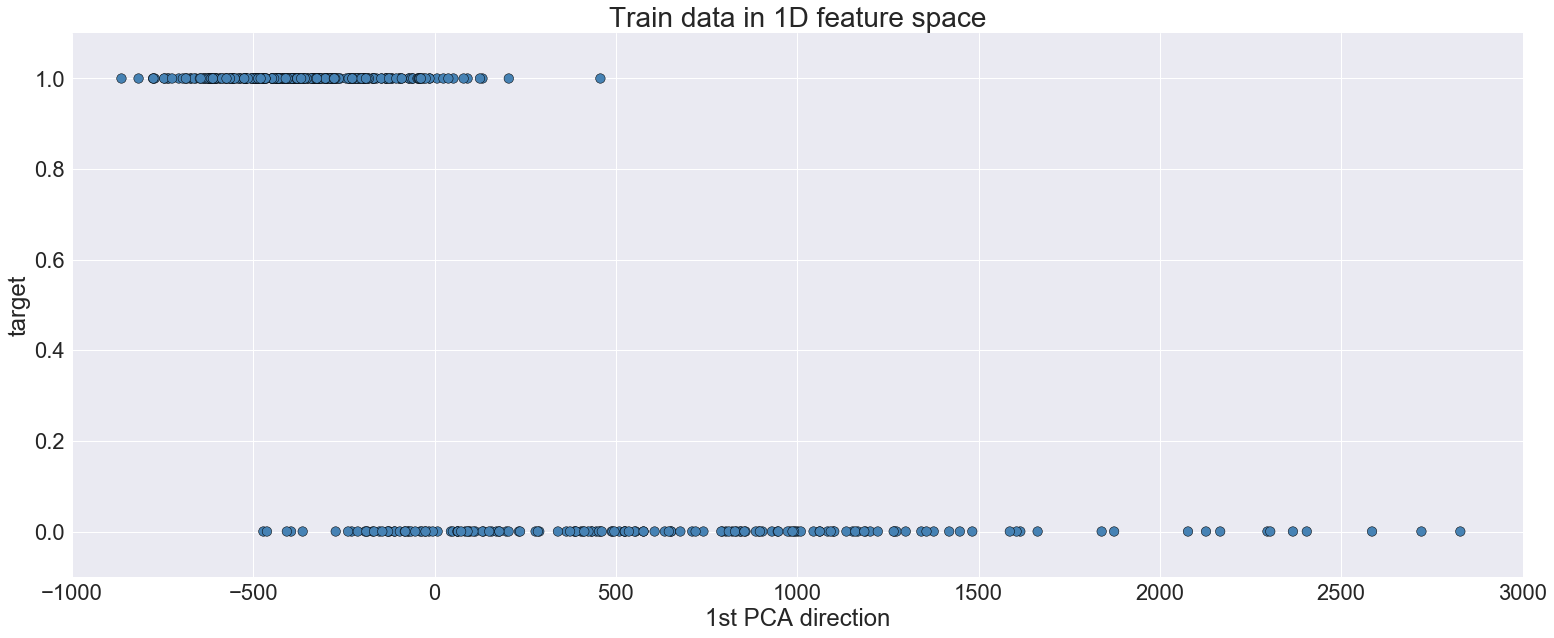

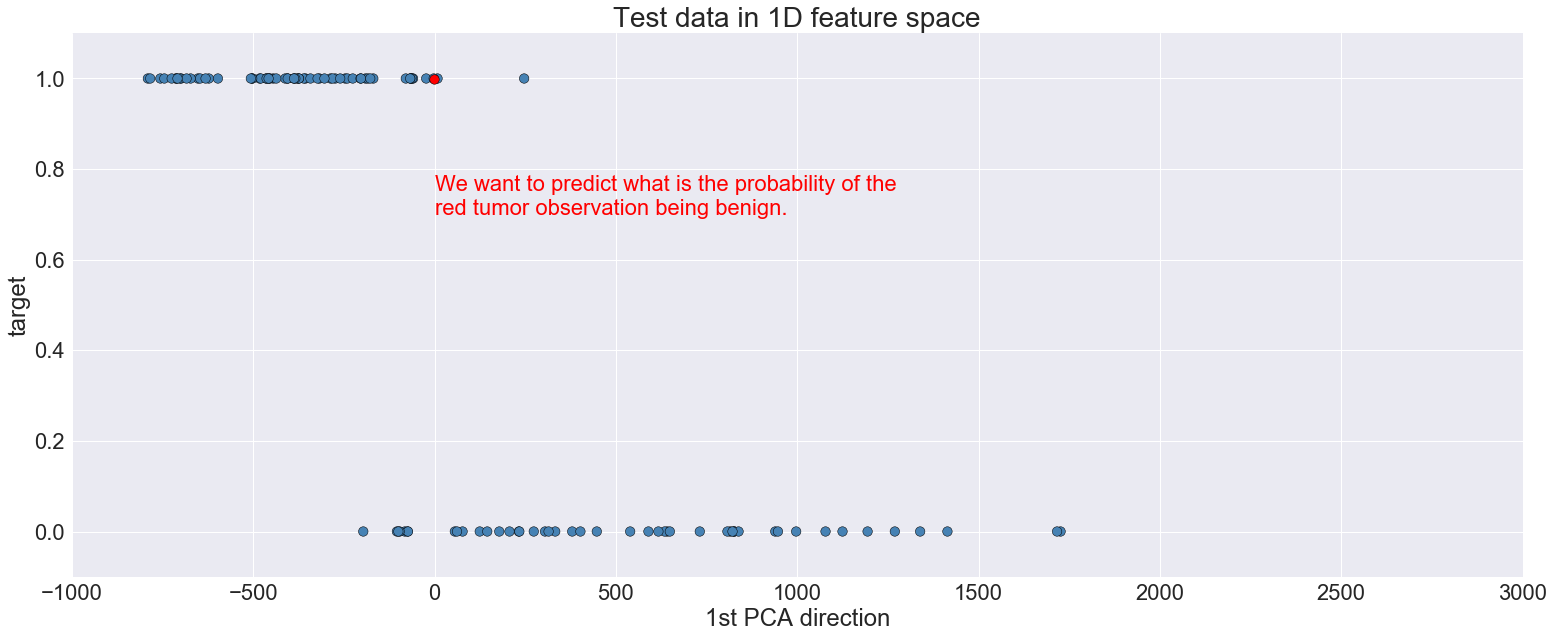

In [8]:
from sklearn.model_selection import train_test_split

# Set test size of 20%
test_size = 0.20

# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = test_size)

plot_1d(X_train, y_train, title = 'Train data in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,xlims = [-1000, 3000])    

plot_1d(X_test, y_test, title = 'Test data in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]        
       ,xlims = [-1000, 3000]
       ,featured = 1);

Next, we want to fit the logistic regression model to training data. However, to first build up our intuition we will start with a simple linear regression model. Recall the linear regression equation with one explanatory variable:

\begin{align*}
y = F(\mathbf{x}) = \mathbf{x} '  \mathbf{\beta} = \beta_0 + \beta_1 x_1
\end{align*}

In our case the sole explanatory variable is the 1st principal component. We fit the linear regression model to data using least-squares minimization. This produces us a linear line through the training observation in two-dimensional plane where the 1st principal component is on x-axis and the binary dependent variable on y-axis:


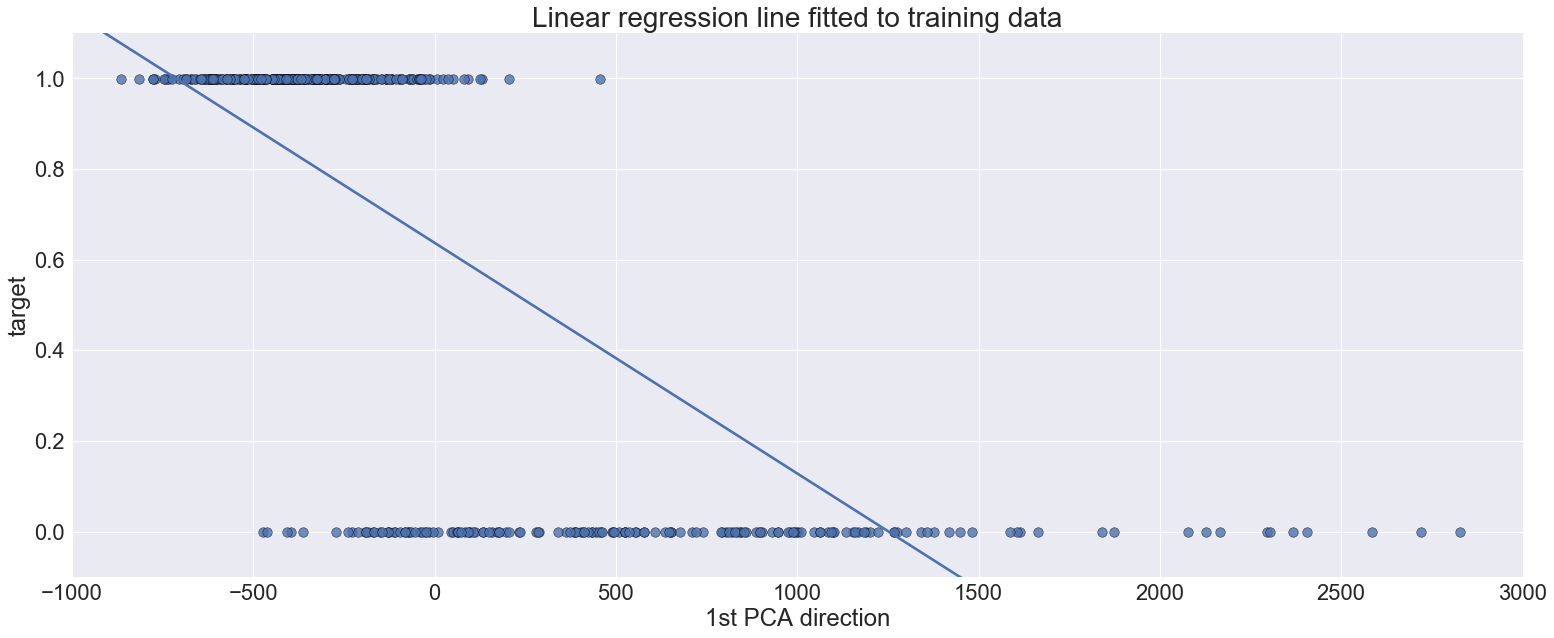

In [9]:
df_temp = pd.DataFrame({'x':X_train[:,0], 'y':y_train})
plot_linreg(df_temp)

The fitted line looks nice and from the negative slope we can deduce that as the value of first principal component increases the value of dependent variable decreases, that is the more likely it is that the tumor is malignant (target = 0).  

Linear regression is not, however, optimally suited for our task of predicting whether a tumor is malignant or benign as mathematical assumptions behind linear regression model are violated when the dependent variable is not continuous. In addition, linear regression may make nonsensical predictions for a binary dependent variable. This is where the logistic regression steps onto stage. Whereas in ordinary linear regression we directly regress the dependent variable <i>y</i>, in logistic regression we regress the <i>probability</i> of the observation belonging to certain target class.

We introduce the <b>logistic function</b> $\sigma(z)$ having the form

\begin{align*}
\sigma(z) &= \frac{e^{z}}{e^{z} + 1}
\end{align*}

Logistic function has an S-like shape and it squeezes any given input value $z$ between 0 and 1. Below we show an example of a logistic curve plotted below for values of z in the interval $[-5, 5]$. Since the values of logistic functions are constrained between 0 and 1, it can be interpreted as mapping the input interval into a probability <i>p</i>. That is, $p = \sigma(z)$

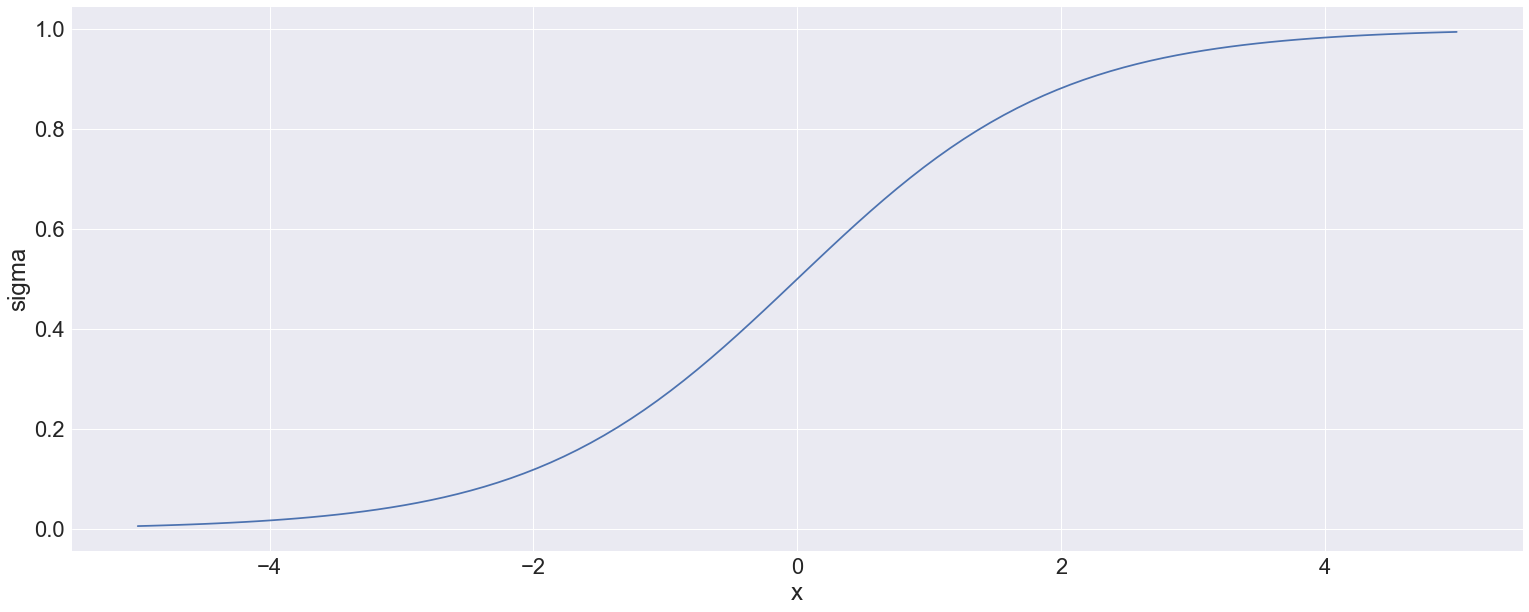

In [10]:
x = np.linspace(-5, 5, 100)
sigma = np.exp(x) / (1 + np.exp(x))
plot_sigmoid(x,sigma)

Compared to linear regression equation, in logistic regression the term on the left-hand side of the regression equation is the so-called <b>logit</b> (or <i>log-odds</i>):

\begin{align*}
logit(p) = ln \big( \frac{p}{1-p} \big) = \mathbf{x} '  \mathbf{\beta}
\end{align*}

It is relatively easy to show that the inverse of logit is just the logistic function:

\begin{align*}
p = \sigma(\mathbf{x}) = \frac{e^{\mathbf{x}'\beta}}{e^{\mathbf{x}'\beta} + 1}  
\end{align*} 

That is, instead of regressing the dependent variable values as in linear regression, <b>in logistic regression we regress the logit which is inverse of the logistic function</b>. The link between linear regression becomes clear: applying logistic function to the right-hand side of the linear regression equation effectively squishes the regression line to be bounded between interval $[0,1]$. Thus, the output of logistic regression can be interpreted as the probability of dependent variable equaling 1, that is in our case the probability of tumor being benign. The probability of tumor being malignant is of course 1 minus the benign probability.

Below we show logistic function that is fit into training data.

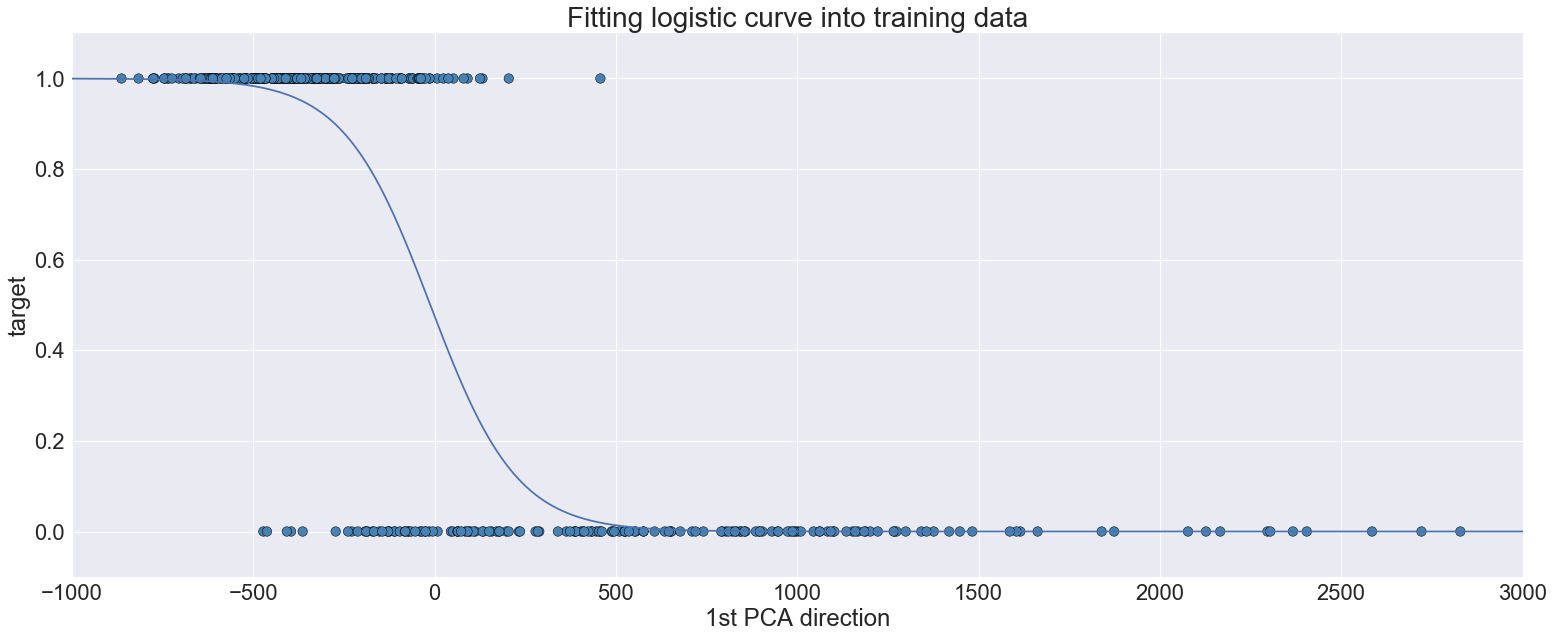

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Pick only one feature
exog = X_train[:,0].reshape((len(X_train),1))

# Scikit learn for accuracy
C = 1e9
model = LogisticRegression(C = C, fit_intercept = True, penalty = 'l1')
model.fit(exog, y_train)
y_pred_1d = model.predict(X_test[:,0].reshape((len(X_test),1)))
y_probs_1d = model.predict_proba(X_test[:,0].reshape((len(X_test),1)))
#print('scikit learn intercept {0:.5f} and coefficient {1:.5f}: '.format(model.intercept_[0], model.coef_[0,0]))

# statsmodel for p-values
import statsmodels.api as sm
endog = y_train
exog = sm.add_constant(exog)
logit = sm.Logit(endog, exog)
logit_res = logit.fit(disp=0)

# plot
x_ax = np.linspace(-1000.0, 4000.0, num = 5000)
y_ax = np.exp(model.intercept_[0] + model.coef_[0,0] * x_ax) / (1 + np.exp(model.intercept_[0] + model.coef_[0,0] * x_ax))

plot_1d(X_train, y_train, title = 'Fitting logistic curve into training data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax],xlims = [-1000, 3000])    

We can display the results from training the logistic regression model in a table. We see that the 1st principal component is statistically significant whereas the intercept is not.

In [12]:
display(logit_res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Aug 2018   Pseudo R-squ.:                  0.6464
Time:                        23:12:44   Log-Likelihood:                -105.35
converged:                       True   LL-Null:                       -297.99
                                        LLR p-value:                 8.868e-86
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1113      0.209     -0.533      0.594      -0.521       0.298
x1            -0.0084      0.001     -8.982      0.000      -0.010      -0.007
==============================================================================
"""

Let's take a closer look at the featured observation which we colored red earlier. We can draw a vertical line from this observation which crosses the fit logistic curve. The point of crossing of the curves tells the <b>model implied probability of the featured observation being benign (target = 1)</b>. In this case our model assigns a higher probability of observation being malignant (52.1%) although the correct label for the observation in question is benign!

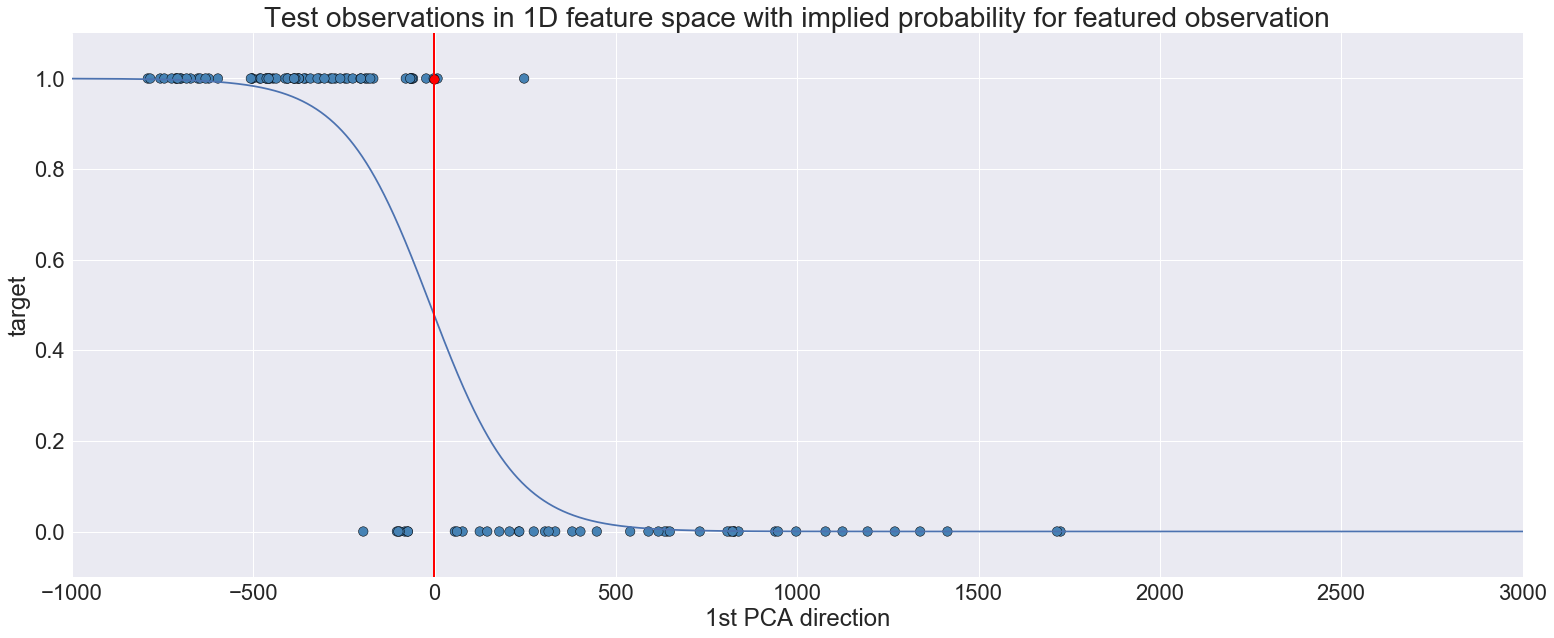

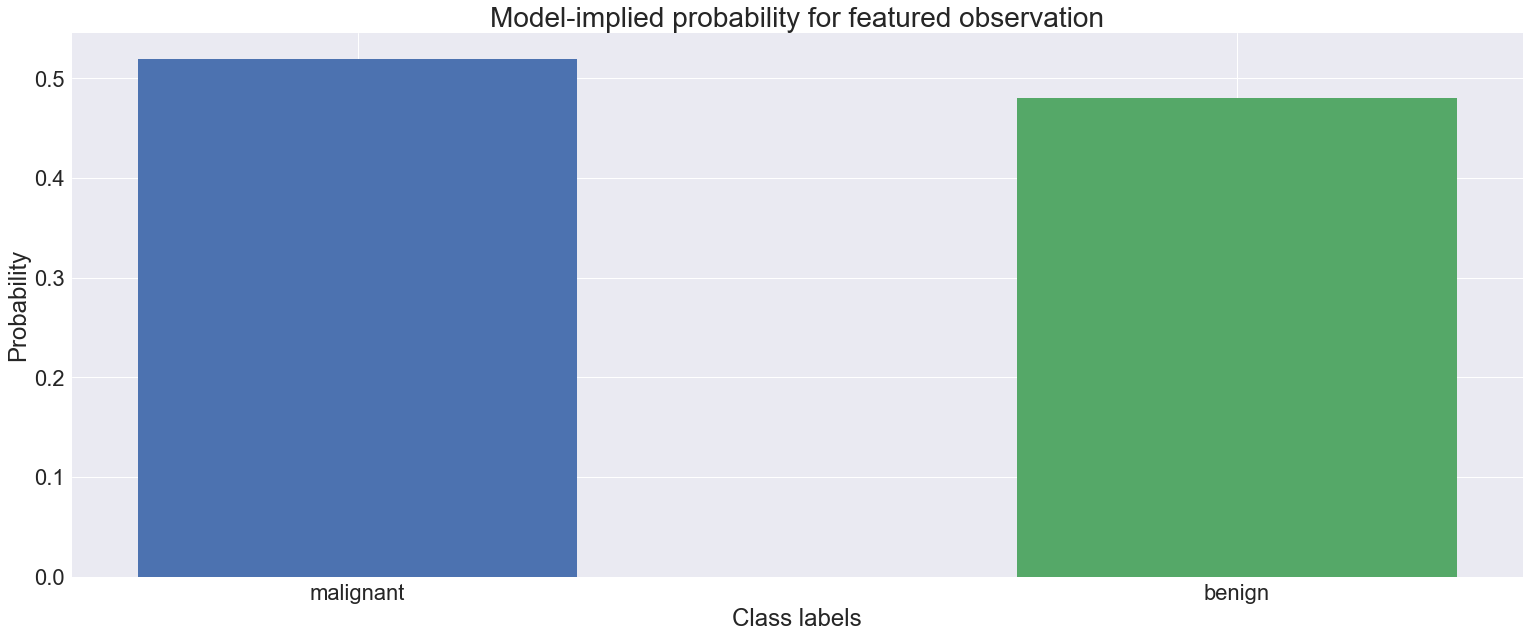

In [13]:
plot_1d(X_test, y_test, title = 'Test observations in 1D feature space with implied probability for featured observation'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax]
       ,xlims = (-1000, 3000)
       ,featured = 2)   

plot_bars(y_probs_1d, 113)    

## Evaluating 1-feature model performance

Now that we have built a model that can predict the probability of a tumor observation being either malignant or benign, we want to evaluate how well it performs. This is done by combining the model with a <i>decision rule</i> which turns our logistic regression model into a <i>classifier</i>. As discussed above, we will use the test sample we put aside earlier in performance evaluation. This is important as we want our model to be such that in generalizes well onto new data and not just learn the training sample 'by heart'.

Classification means identifying to which target class a new observation belongs. Say we decide that every observation with predicted bneign probability of over 50% is classified as benign, and rest classified as malignant. Then we have essentially assigned a decision rule of $p = 0.5$ to be used in conjunction with our model. What this means in our one-dimensional feature space plot is that we first draw a vertical line that intersects the fitted logistic curve at $y = 0.5$.

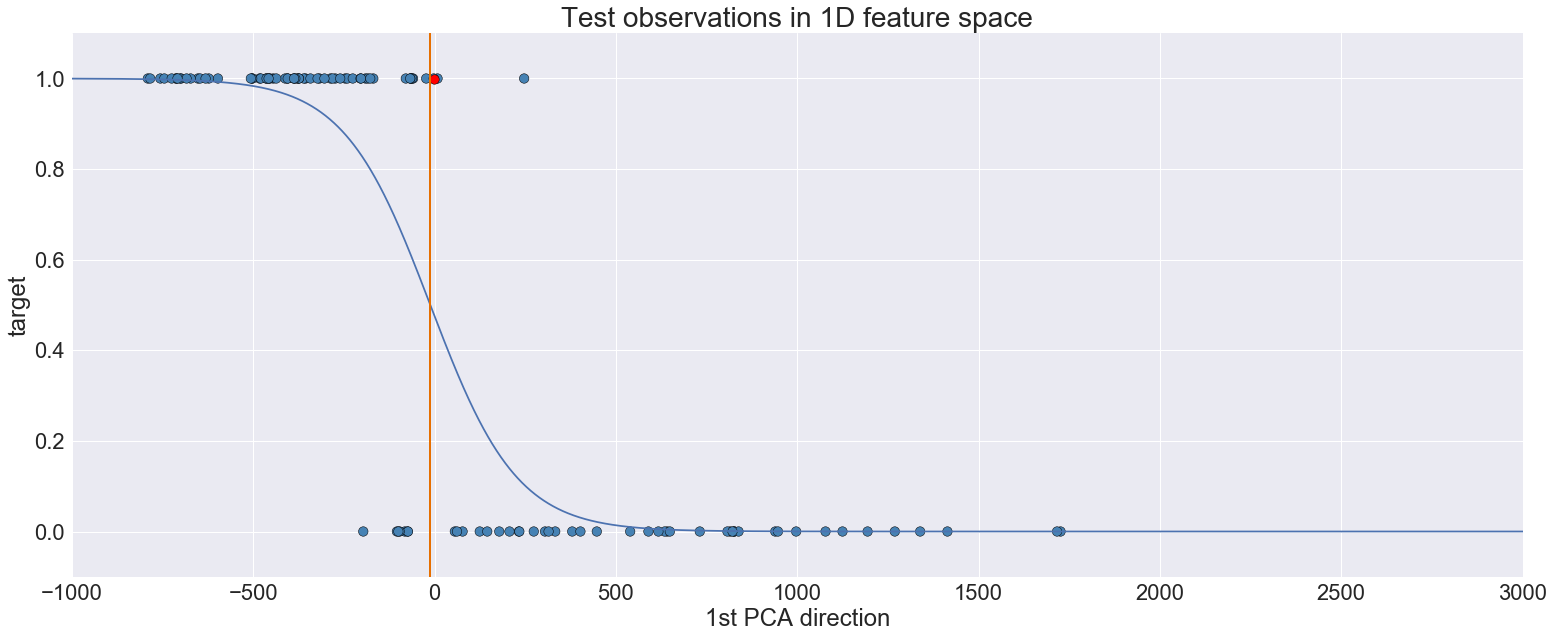

In [14]:
plot_1d(X_test, y_test, title = 'Test observations in 1D feature space'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
       ,log_curve = [x_ax, y_ax]
       ,xlims = (-1000, 3000)        
       ,featured = 3) 

All benign observations (target = 1) that reside to left of the brown vertical line are correctly classified as benign observations (we call these <i>true positives, TP</i>), whereas benign observations to the right of the brown line are incorrectly classified as malignant observations (<i>false negatives, FN</i>). Conversely, malignant observations (target = 0) that reside to the right of the vertical line are correctly classified as malignant (<i>true negatives, TN</i>), whereas malignant observations to the left of the vertical curve are incorrectly classified as benign (<i>false positives, FP</i>). As we see, our featured (benign) observation is incorrectly classified as malignant.

When we run all test samples through our classifier, with <i>confusion matrix</i> we can keep track how many TP/FN/TN/FN's we've got. Whereas majority of the test sample observations are classified correctly, our model has made 7 false negative and 3 false positive predictions. There exists many different metrics with which to evaluate the predictive power of a model and it depends on the application at hand which of these is the most appropriate. However, one of the most often used metrics is <i>accuracy</i> (Acc), defined as

\begin{equation}
Acc = \frac{TP + TN}{TN + TP + FN + FP}
\end{equation}

As we can see, accuracy measures the ratio of correct predictions to all predictions made. The more we correct predictions, the higher the accuracy and the better our model fairs. In the image below we see that our 1-featured model fairs with accuracy of 0.912.

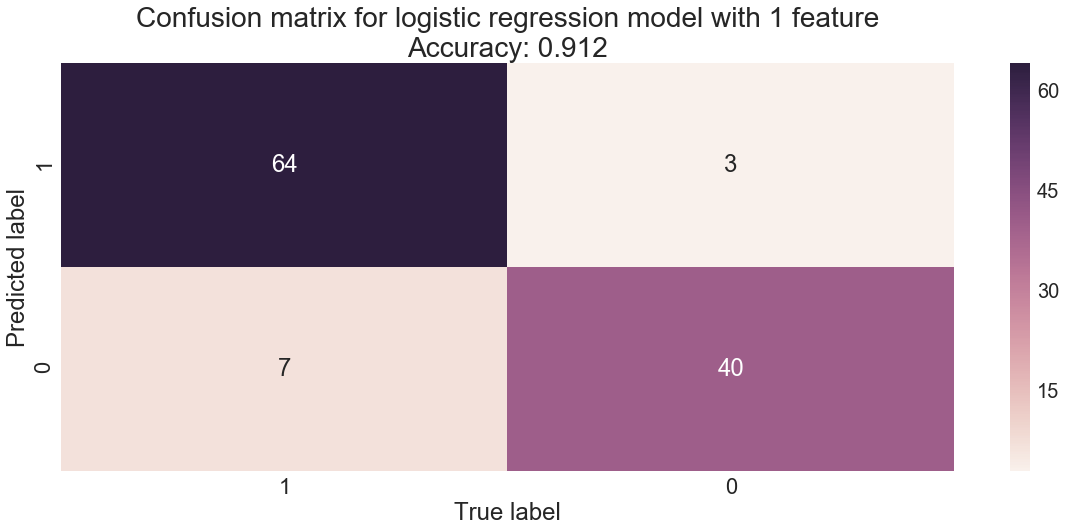

In [15]:
plot_confusion_matrix(y_test, y_pred_1d, title = 'Confusion matrix for logistic regression model with 1 feature')

In [16]:
# Below cell is not important, used only to store variables for visualization video.
# Save plots for animations
#fig = plot_1d(X_test, y_test, title = 'Test observations in 1D feature space'
#       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
#       ,log_curve = [x_ax, y_ax]
#       #,xlims = (-1363.14230778, 4367.17805308)
#       ,xlims = (-1000, 2000)        
#       ,featured = 4
#       ,style = 'animation') 
#fig.savefig('animation_1dresult.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)
#
#fig = plot_confusion_matrix(y_test, y_pred_1d, title = 'Confusion matrix for logistic regression model with 1 feature', style = 'animation')
#fig.savefig('animation_1dconfusionmatrix.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)

## Model with two features

Let us now introduce the second principal component as second feature into our model. We divide the data into train and test samples as in 1-dimensional feature space case. X-axis still exhibits the 1st PC and y-axis now becomes the 2nd principal component. Dependent variable (having either value 0 or 1) is designated by the color of the node.

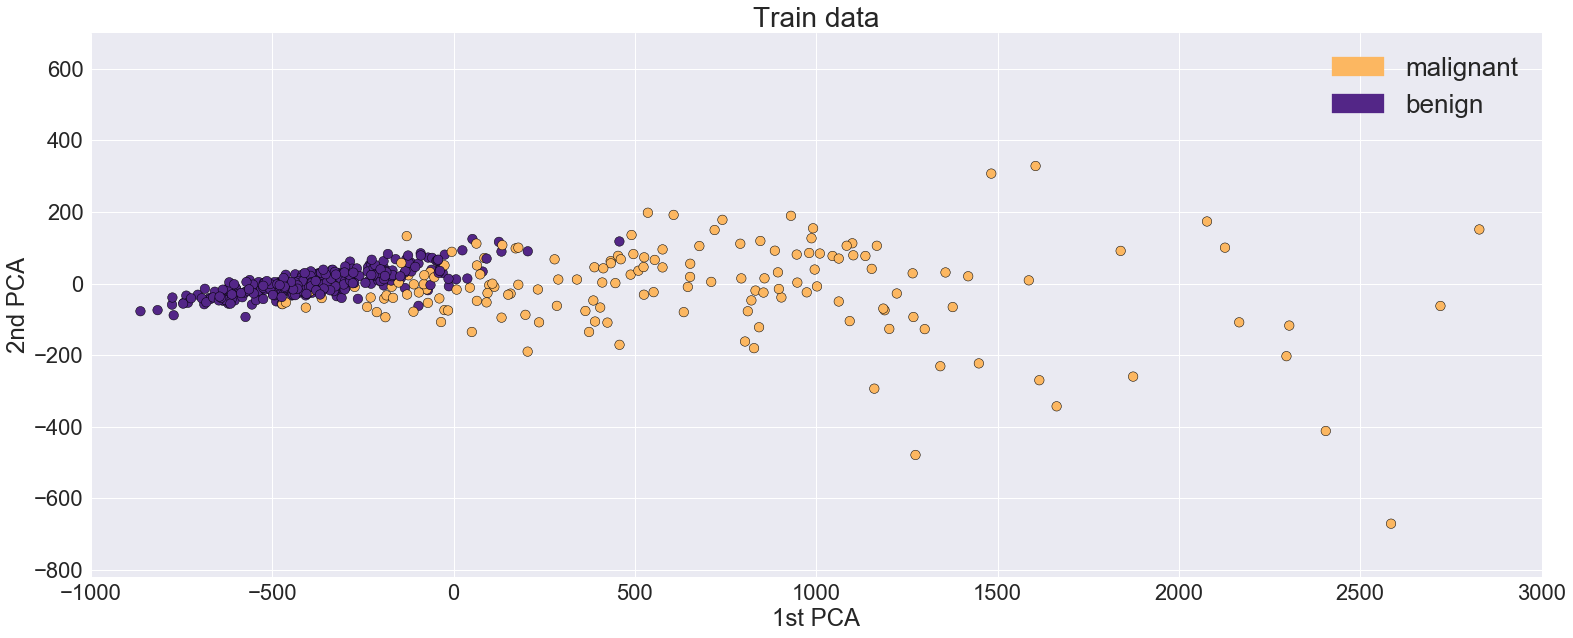

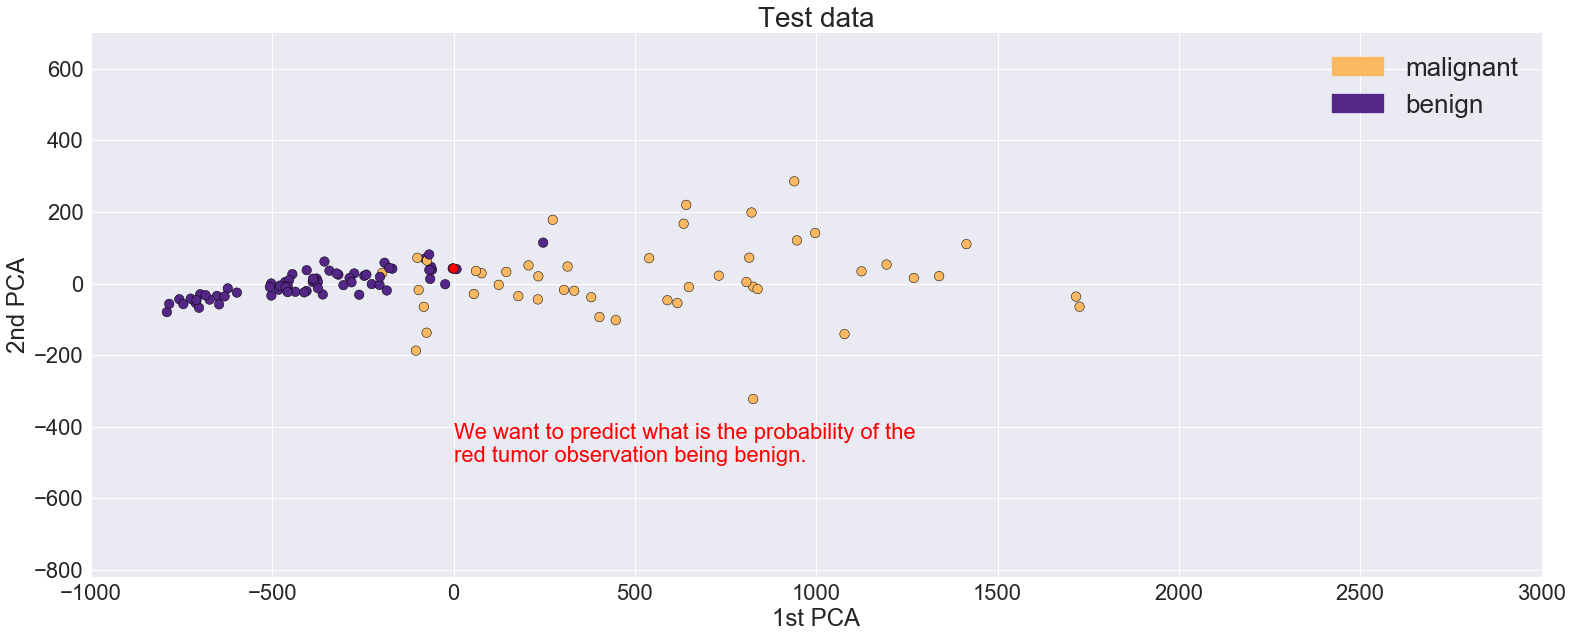

In [17]:
plot_2d(X_train, y_train, title = 'Train data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]]
        ,lims = (-1000, 3000, -820, 700))

plot_2d(X_test, y_test, title = 'Test data'
       ,class_names = [dataset.target_names[0], dataset.target_names[1]], featured = 1
       ,lims = (-1000, 3000, -820, 700));

Let us now fit the model with two features. We will plot a similar graph as the sigmoid curve above but this time in two-dimensional feature space. We use color gradient to designate the probability of a given point to be predicted either as malignant or benign. The darker the background color (purple for benign and orange for malignant observations), the higher the predicted probability of either class membership. Along the white fjord the probability of an observation being benign is about 50%, meaning that here the model is unsure about its prediction.

Optimization terminated successfully.
         Current function value: 0.172227
         Iterations 9


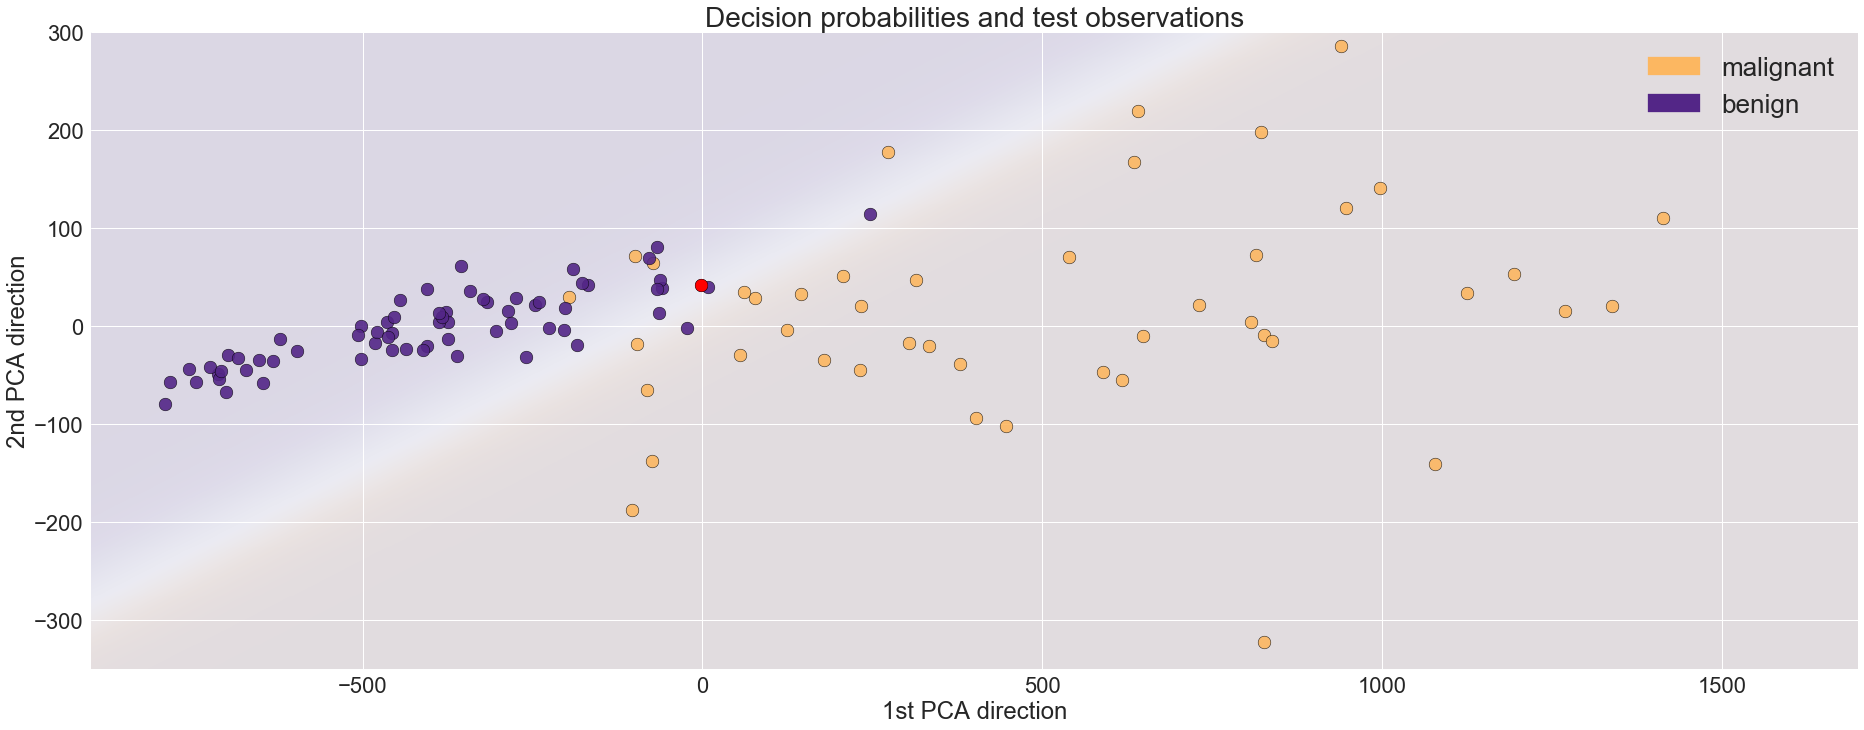

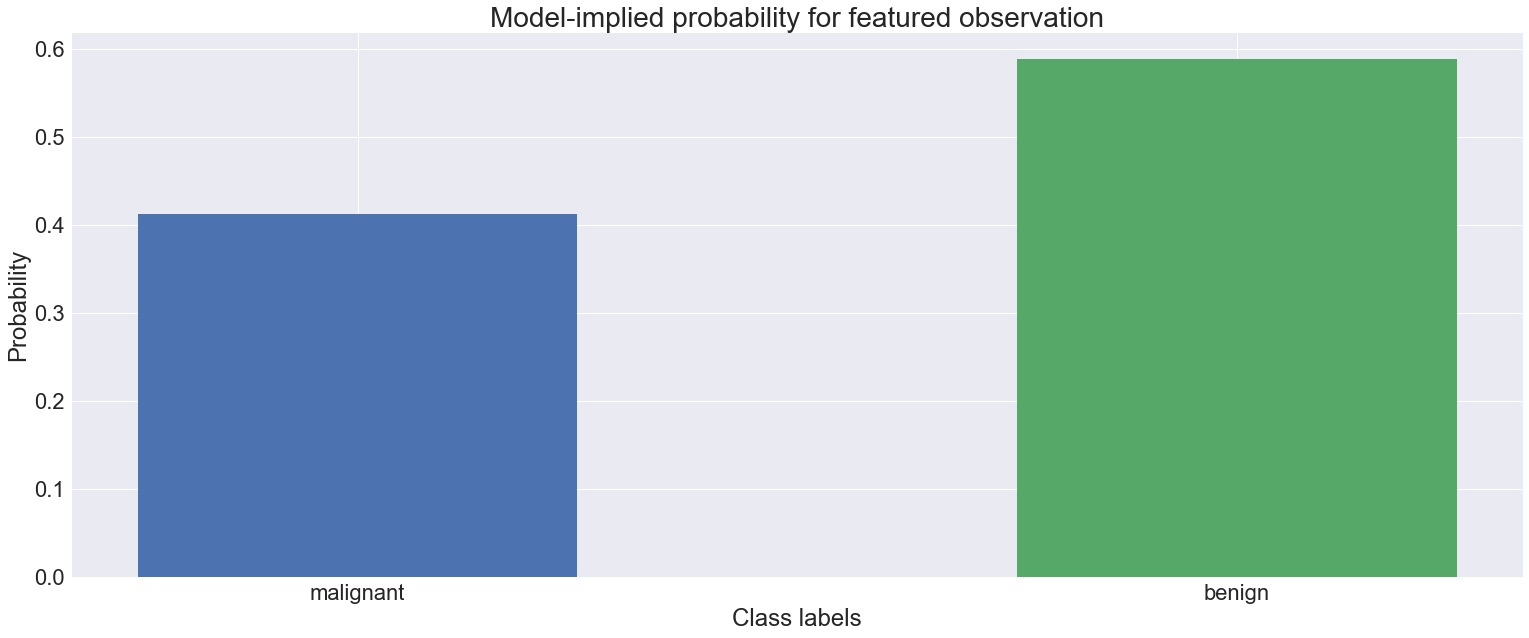

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Scikit learn for accuracy
C = 1e9
model = LogisticRegression(C = C)
model.fit(X_train, y_train)
y_pred_2d = model.predict(X_test)
y_probs_2d = model.predict_proba(X_test)
#print('scikit learn estimates',model.intercept_, model.coef_)

# statsmodel for p-values
import statsmodels.api as sm
endog = y_train
exog = sm.add_constant(X_train)
logit = sm.Logit(endog, exog)
logit_res = logit.fit()

# Plot in 2-dimensional feature space 
plot_2d_decision_probs(X_test, y_test, model
                        ,class_names = [dataset.target_names[0], dataset.target_names[1]]
                        ,title = 'Decision probabilities and test observations'
                        ,mesh_step_size = 1, correction = 500
                        ,featured = 1
                        ,lims = (-900, 1700, -350, 300))

plot_bars(y_probs_2d, 113)

Displaying regression results we see that both principal components are statistically significant.

In [19]:
# display regression results
display(logit_res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  455
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            2
Date:                Mon, 27 Aug 2018   Pseudo R-squ.:                  0.7370
Time:                        23:12:47   Log-Likelihood:                -78.363
converged:                       True   LL-Null:                       -297.99
                                        LLR p-value:                 4.147e-96
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1432      0.338     -3.382      0.001      -1.806      -0.481
x1            -0.0122      0.001     -8.597      0.000      -0.015      -0.009
x2             0.0347      0.006      5.972      0.000       0.023       0.046
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We can again use the 0.5 probability decision rule to use the trained logistic regression model as classifier. Whereas in the 1-feature case the decision boundary was a vertical line, here it is an affine line in the two-dimensional feature space. In contrast to the 1-featured model, the featured observation is now correctly classified as benign. Further, looking at the confusion matrix we can see that our model performs overall better; accuracy has increased to 0.947, as the number of false negatives has decreased by 3 and false positives by one. We can deduce that the model built with two features works better than the model with just one feature.

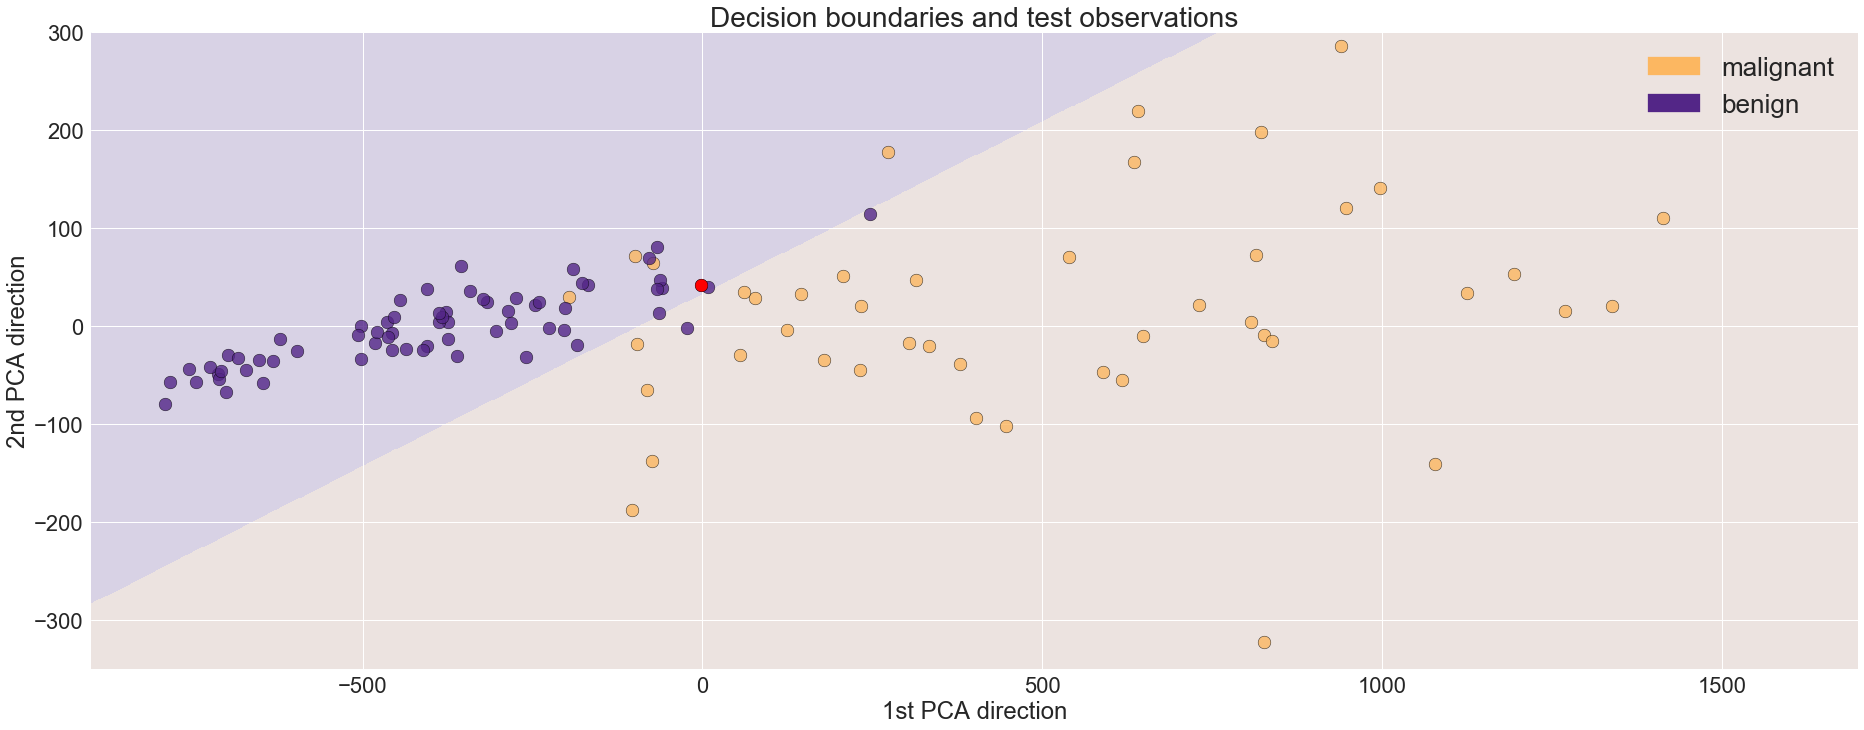

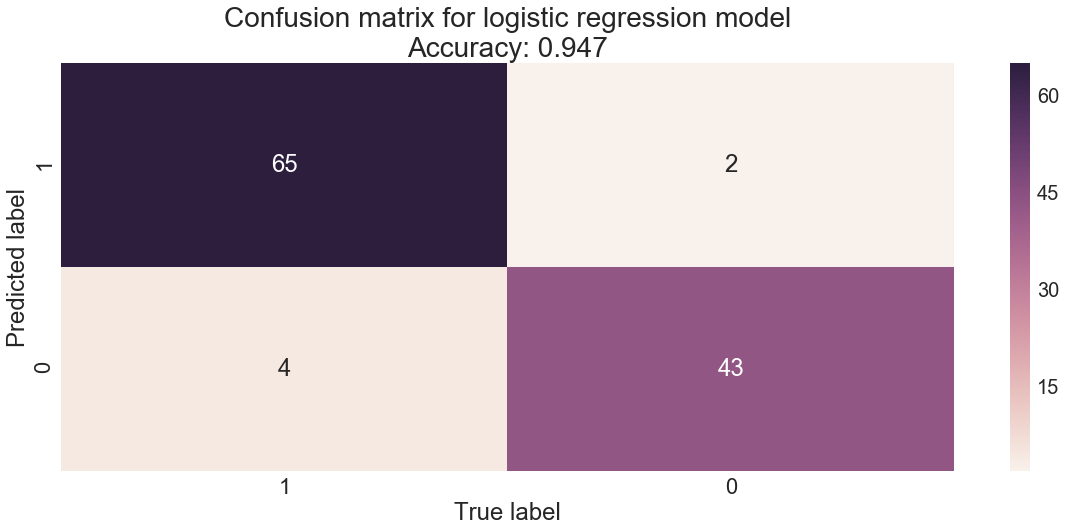

In [20]:
plot_2d_decision_regions(X_test, y_test, model, class_names = [dataset.target_names[0], dataset.target_names[1]], title = 'Decision boundaries and test observations', mesh_step_size = 1, correction = 500, featured = 1
                        ,lims = (-900, 1700, -350, 300))

plot_confusion_matrix(y_test, y_pred_2d, title = 'Confusion matrix for logistic regression model')

In [21]:
# Below cell is not important, used only to store variables for visualization video.
# Save plots for animations
#fig = plot_2d_decision_regions(X_test, y_test, model, class_names = [dataset.target_names[0], dataset.target_names[1]], title = 'Decision boundaries and test observations', mesh_step_size = 1, correction = 500, featured = 0, style = 'animation') 
#fig.savefig('animation_2dresult.svg', facecolor=fig.get_facecolor(), format='svg', dpi=100)
#
#fig = plot_confusion_matrix(y_test, y_pred_2d, title = 'Confusion matrix for logistic regression model with 2 features', style = 'animation')
#fig.savefig('animation_2dconfusionmatrix.svg', facecolor=fig.get_facecolor(), format='svg', dpi=1200)

## Conclusion

In this article we saw how to build a simple predictive model of malignant cancer tumors using logistic regression. We covered the most important steps in a predictive modelling pipeline, from data preparation to model fitting as well as model evaluation. While this introduction and the related Youtube video are just a scratch of the surface when it comes to predictive modelling and machine learning in general, after understanding the core principles shown in them one is in a much better position to start learning more about these subjects.   